# [2023-10-31] Circadian factor stability

In this notebook, we begin to examine the stability of fitted factors.

Specifically, we compare the factors fitted to models $(50, \{4,8\}, 30)$.


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from tqdm.auto import tqdm
import itertools
import numpy as onp
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from dtd.utils import download_wnb_params, get_wnb_project_df
from kf_viz import draw_syllable_factors, draw_circadian_bases, make_tod_series

sns.set_style("darkgrid")

/home/libi/anaconda3/envs/kf/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load all runs associated with (K1=50, K2={4,8}, K3=30)

Pull data from WandB server into a Pandas dataframe.

In [2]:
# Project is specified by <entity/project-name>
wnb_entity = 'eyz'
wnb_project = 'kf-dtd-231022'

config_keys = ['seed', 'k1', 'k2', 'k3']
summary_keys = ['pct_dev']

df = get_wnb_project_df(wnb_entity, wnb_project, config_keys, summary_keys)

In [3]:
# Choose runs for which (K1=50, K2=4)
df = df[(df['k1'] == 50) \
        & ((df['k2'] == 4) | (df['k2'] == 8)) \
        & (df['k3'] == 30)]

# Drop rows that have NaN pct_dev
df = df.dropna(axis=0)

print(f"{len(df)} total runs, {df['k2'].nunique()} unique K_2 ranks: {sorted(df['k2'].unique())}")

9 total runs, 2 unique K_2 ranks: [4, 8]


## Evaluate K2=4 factors

I expected the model with $K_3=100$ to be overfit to the data, and hence for the held-out log likelihood to be lower
than simpler models that do not overfit to the data. However, this may be too naive of an assumption.

# Fitted behavioral topics

Text(0.5, 0.98, 'k2 = 4')

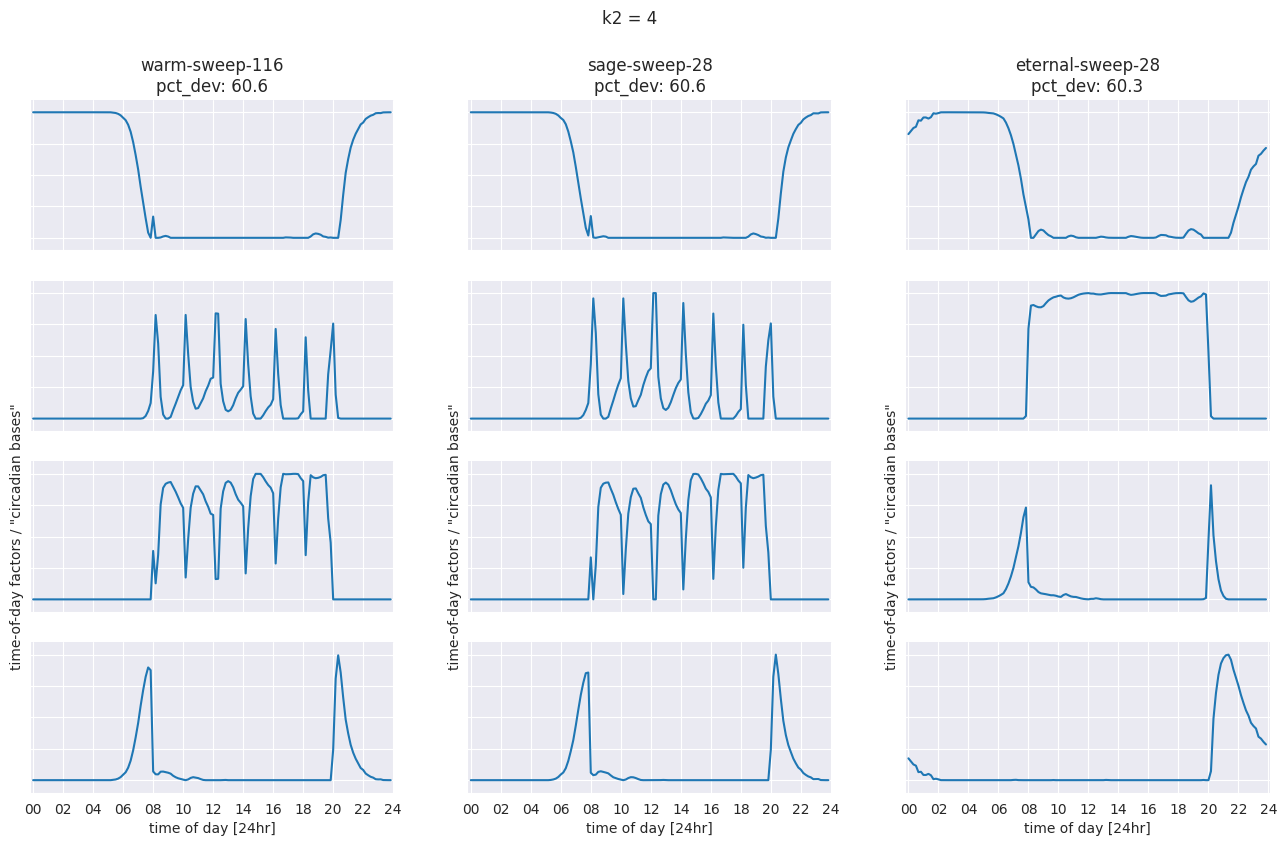

In [4]:
wnb_entity = 'eyz'
wnb_project = 'kf-dtd-231022'

k2 = 4

# -------------------------------------------
update = True
subdf = df[df['k2'] == k2]
param_dicts = [download_wnb_params(wnb_entity, wnb_project, _id, update=update) for _id in subdf['id']]

# -------------------------------------------
fig = plt.figure(figsize=(16,9))

n_runs = len(subdf)
gs_outer = GridSpec(nrows=1, ncols=n_runs, figure=fig)

for i_run, _param_dict in enumerate(param_dicts):
    _params = (_param_dict['G'], _param_dict['F1'], _param_dict['F2'], _param_dict['F3'])
    gs_inner = gs_outer[i_run].subgridspec(k2, 1)
    
    axs = [fig.add_subplot(gs_inner[i_k]) for i_k in range(k2)]
    draw_circadian_bases(_params, axs=axs)

    axs[0].set_title(f"{subdf.iloc[i_run]['name']}\npct_dev: {subdf.iloc[i_run]['pct_dev']:.1f}")

fig.suptitle(f'k2 = {k2}')

## Evaluate on K2=8

Text(0.5, 0.98, 'k2 = 8')

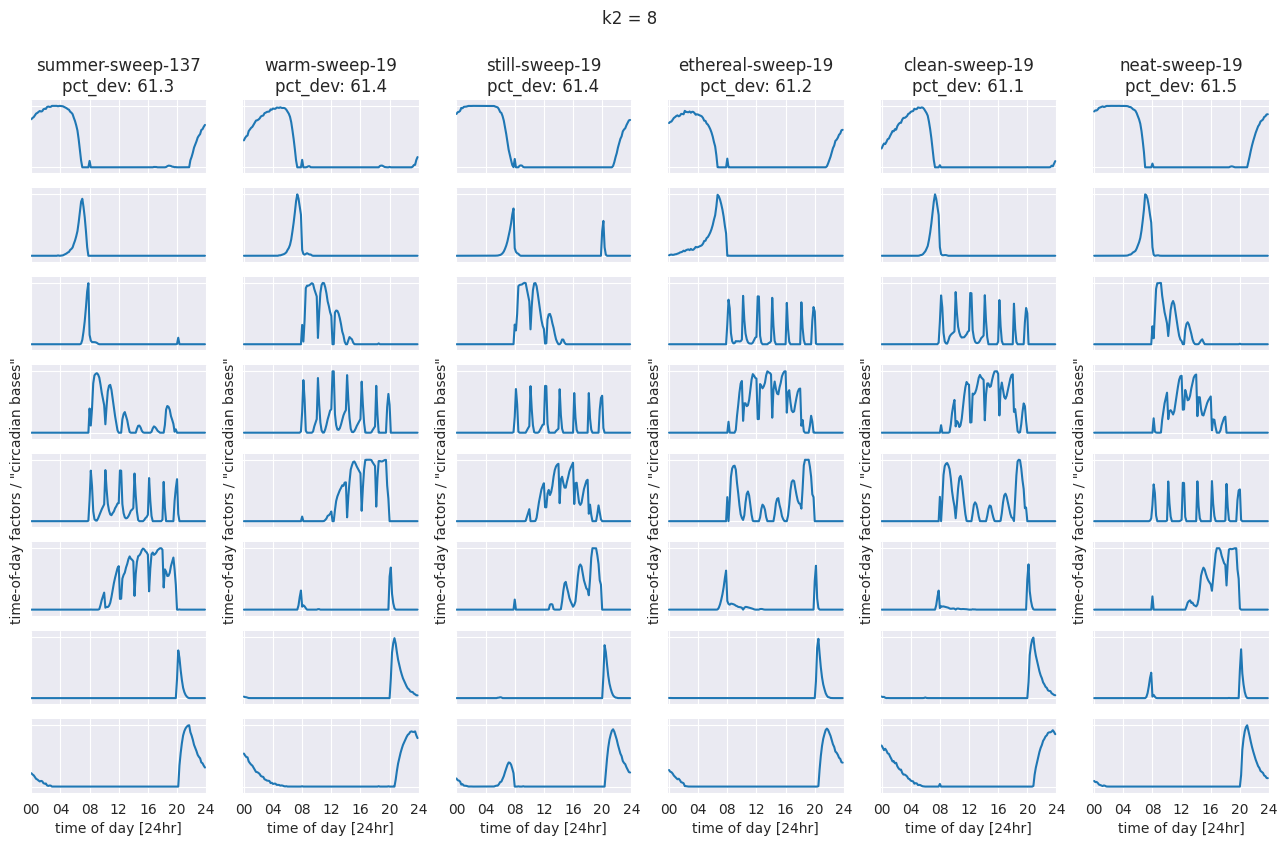

In [5]:
k2 = 8

# -------------------------------------------
subdf = df[df['k2'] == k2]
param_dicts = [download_wnb_params(wnb_entity, wnb_project, _id) for _id in subdf['id']]

# -------------------------------------------
fig = plt.figure(figsize=(16,9))

n_runs = len(subdf)
gs_outer = GridSpec(nrows=1, ncols=n_runs, figure=fig)

for i_run, _param_dict in enumerate(param_dicts):
    _params = (_param_dict['G'], _param_dict['F1'], _param_dict['F2'], _param_dict['F3'])
    gs_inner = gs_outer[i_run].subgridspec(k2, 1)
    
    axs = [fig.add_subplot(gs_inner[i_k]) for i_k in range(k2)]
    draw_circadian_bases(_params, tod_freq='4H', axs=axs)

    axs[0].set_title(f"{subdf.iloc[i_run]['name']}\npct_dev: {subdf.iloc[i_run]['pct_dev']:.1f}")

fig.suptitle(f'k2 = {k2}')

# umap embedding to identify stable factors

In [5]:
from umap import UMAP

k2 = 8

# -------------------------------------------
subdf = df[df['k2'] == k2]
param_dicts = [download_wnb_params(wnb_entity, wnb_project, _id) for _id in subdf['id']]

# Reshape all factors into a (n_samples, n_time_bins)
# (n_runs, n_time_bins, n_factors)
all_f2s = [param_dict['F2'] for param_dict in param_dicts]
all_f2s = onp.stack(all_f2s, axis=0)
n_cv, D2, K2 = all_f2s.shape

# rehshape to (n_runs * n_factors, n_time_bins)
all_f2s = all_f2s.transpose(0,2,1).reshape(-1,D2)


/home/libi/anaconda3/envs/kf/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Sweep over umap hyperparameters

We believe that the factors realized across all runs (of a given model rank) come
from some low number of clusters. So, we seek hyperparameters that maximize factor clustering

In [29]:
n_neighbors_list = [2, 3, 4, 5, 7, 10, 20,]
min_dist_list = [0.0, 0.05, 0.1, 0.15, 0.2] # range between 0 and 1
arr = all_f2s

nd_params = [{'n_neighbors': n_neighbors_list[i_row], 'min_dist': min_dist_list[i_col]}
             for i_row, i_col in itertools.product(range(len(n_neighbors_list)), range(len(min_dist_list)))]

# Squat matrices, more params goes on col dim
row_name, row_arr, col_name, col_arr = \
    ('n_neighbors', n_neighbors_list, 'min_dist', min_dist_list) \
    if len(n_neighbors_list) < len(min_dist_list) \
    else ('min_dist', min_dist_list, 'n_neighbors', n_neighbors_list)

nrows, ncols = len(row_arr), len(col_arr)

ncomponents = 2
umap_ndarrays = onp.zeros((len(row_arr), len(col_arr), len(arr), ncomponents))
for i_row, i_col in tqdm(itertools.product(range(len(row_arr)), range(len(col_arr))), total=nrows*ncols):
    fit = UMAP(**{row_name: row_arr[i_row], col_name: col_arr[i_col]})
    umap_ndarrays[i_row, i_col] = fit.fit_transform(arr)

21it [00:39,  1.86s/it]


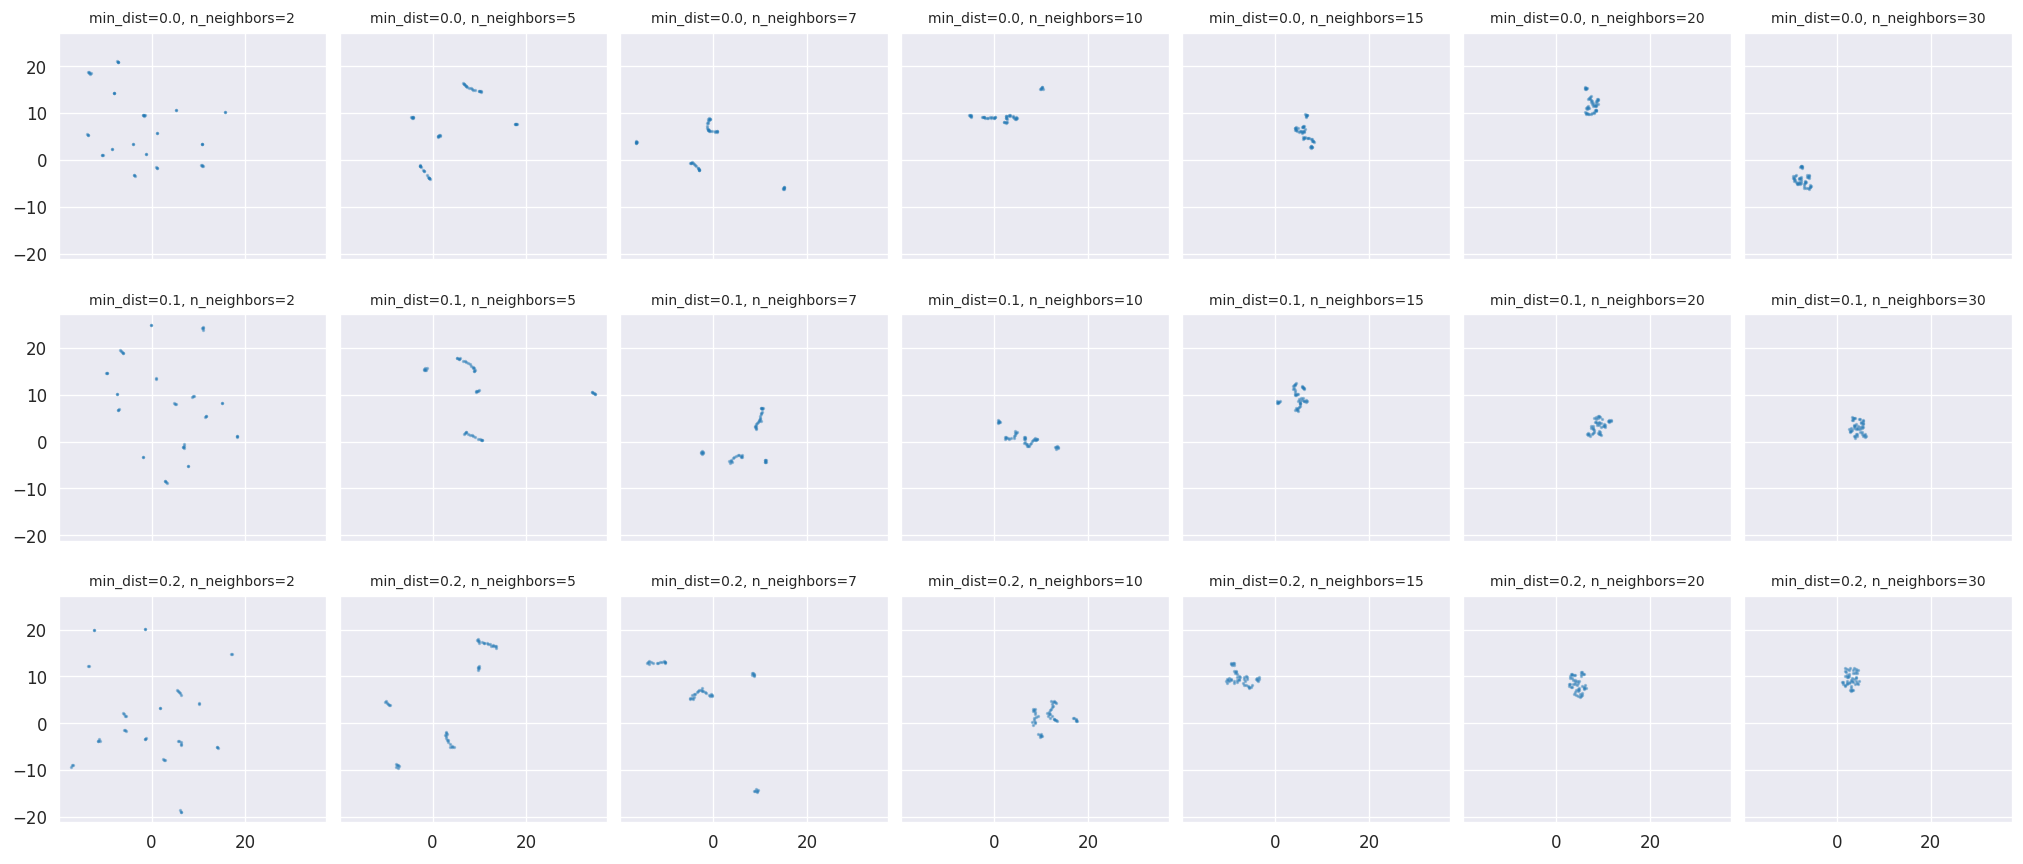

In [30]:
fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True,
                        figsize=(3*ncols,3*nrows), dpi=120,
                        gridspec_kw={'hspace':0.05, 'wspace': 0.05})

for (i_row, i_col), ax in onp.ndenumerate(axs):
    u = umap_ndarrays[i_row, i_col]

    ax.scatter(u[:,0], u[:,1], s=4, alpha=0.4, marker='.')
    ax.set_aspect('equal')
    ax.set_title(f'{row_name}={row_arr[i_row]}, {col_name}={col_arr[i_col]}', fontsize='small')

## Examining umap clustering

We find that `min_dist={0,0.1}` and `n_neighbors=[5,7]` also consistently have 4-5 clusters (in 2D space).
We dive into one choice of hyperparameters

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


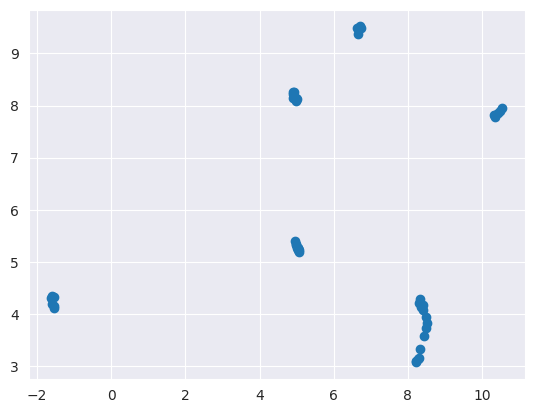

In [7]:
arr = all_f2s
min_dist = 0.1  # This looks best above, and this is the default umap parameter
n_neighbors = 5 # This is 10% of the data

# Embed factors in 2D space. Do not use any dimensionality reduction
fit = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=arr.shape[-1])
u = fit.fit_transform(arr)

# Verify that its clumpy
plt.scatter(u[:,0], u[:,1], color='k', marker='.');

### Sweep over K-means n_clusters parameter

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

arr = all_f2s

n_clusters_list = onp.arange(2, 3*K2+1)
n_runs = 5

scores = onp.zeros((n_runs, len(n_clusters_list)))

for i_run in tqdm(range(n_runs)):
    for i_cluster, n_clusters in enumerate(n_clusters_list):
        kmeans = KMeans(n_clusters=n_clusters).fit(arr)
        scores[i_run, i_cluster] = silhouette_score(arr, kmeans.labels_, metric='euclidean')

100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Text(0.95, 0.05, 'n=5 runs')

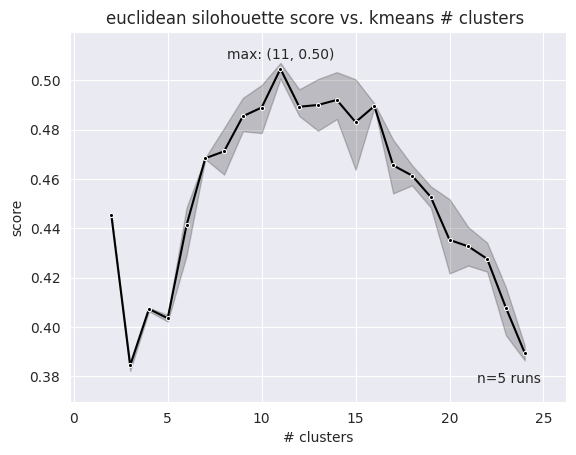

In [52]:
kmeans_df = pd.DataFrame({'# clusters': onp.tile(n_clusters_list, n_runs),
                          'score': scores.ravel()})

sns.lineplot(kmeans_df, x='# clusters', y='score', marker='.', color='k')

# Increase margins so the plot ais less squished with all of our annotations
plt.margins(0.1)

# Annotate maximizing point
n_max = int(kmeans_df.groupby('# clusters').mean().idxmax())
max_score = float(kmeans_df.groupby('# clusters').mean().max()) 
plt.annotate(f'max: ({n_max}, {max_score:.2f})', xy=(n_max, max_score), xytext=(0, 0.5), textcoords='offset fontsize',
             ha='center', va='bottom')

# Add meta-info
plt.title(f'euclidean silohouette score vs. kmeans # clusters ')
plt.annotate(f'n={n_runs} runs', xy=(0.95,0.05), xycoords='axes fraction', ha='right')

### Compare raw trace grouping and umap grouping

In [100]:
n_clusters = 11

kmeans = KMeans(n_clusters=n_clusters).fit(arr)
labels = kmeans.labels_
unique_labels, counts_per = onp.unique(labels, return_counts=True)

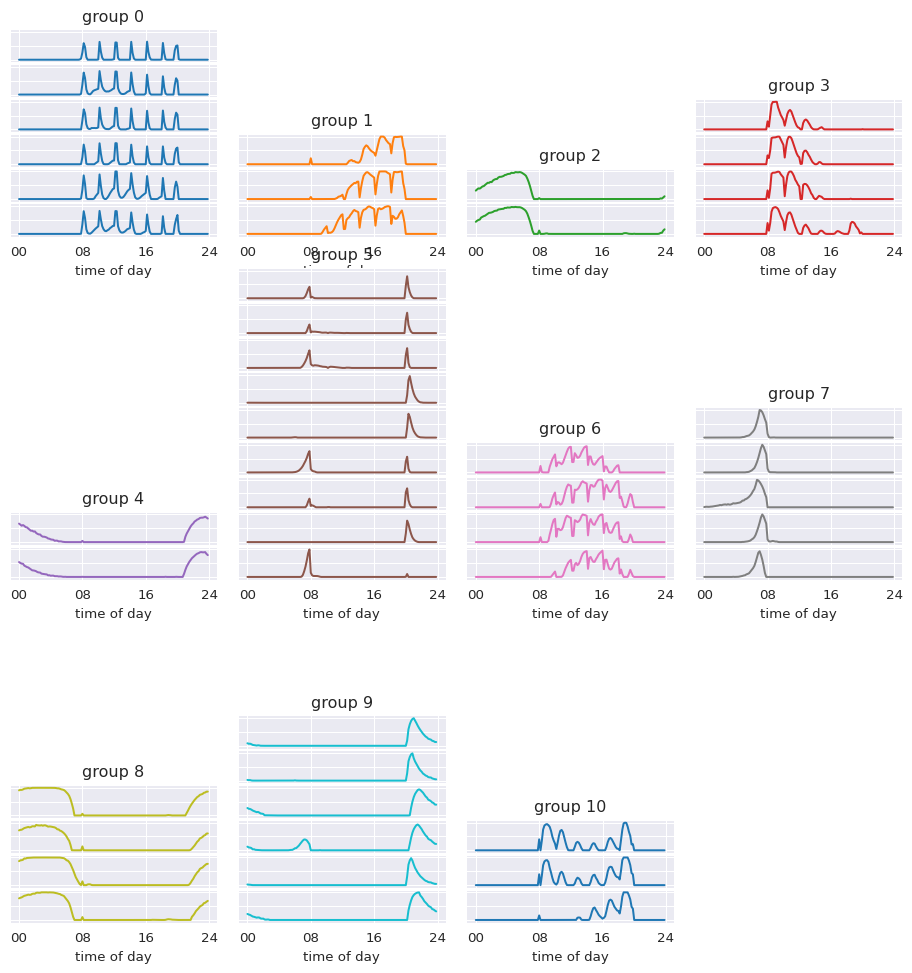

In [196]:
import itertools

# Plot all examples
ncols = 4
nrows = len(unique_labels) // ncols + ((len(unique_labels) % ncols) > 0)

# Number of rows within each subplot
n_subrows = counts_per.max()

fig = plt.figure(figsize=(3*ncols, (n_subrows/2)*nrows), dpi=96)
gs = GridSpec(nrows=nrows, ncols=ncols, hspace=0.1, wspace=0.1)

for (i_row, i_col), lbl in zip(itertools.product(range(nrows), range(ncols)), unique_labels):
    # lbl = unique_labels[i_row*ncols + i_col]
    idxs = onp.nonzero(labels == lbl)[0]

    gs_inner = gs[i_row, i_col].subgridspec(n_subrows, 1, hspace=0.05)
    for i_subrow, idx in enumerate(idxs):
        ax = fig.add_subplot(gs_inner[n_subrows-i_subrow-1])
        ax.plot(arr[idx], color=f'C{lbl}')

        # Set yticks
        ax.set_ylim(-0.1, 1.1)
        ax.set_yticks([0,0.5,1.0])
        ax.tick_params(labelleft=False)
        ax.margins(y=0.5)
        
        # Set x tick labels
        t_dts = make_tod_series('8H')        
        t_locs = onp.concatenate([onp.linspace(0, D2, num=len(t_dts), endpoint=False), [D2]])
        t_labels = list(map(lambda dt: dt.strftime('%H'), t_dts)) + ['24']
        ax.set_xticks(t_locs)
        ax.set_xticklabels(t_labels)

        if i_subrow > 0:
            ax.tick_params(labelbottom=False)
        else:
            ax.set_xlabel('time of day')
        
    # Title the column of axes. Since we are plotting bottom to top
    # this ax can be found at the end of the for loop
    ax.set_title(f'group {lbl}')


Text(0.5, 0.98, 'umap embedding, colored by kmeans cluster')

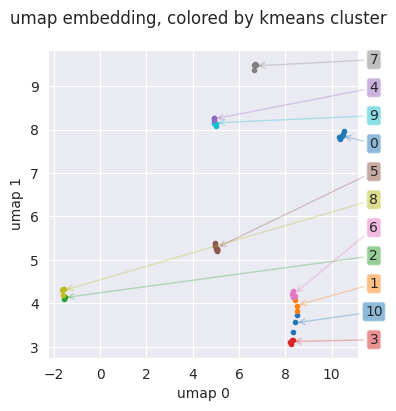

In [194]:
fig, ax_2d = plt.subplots(figsize=(4,4))

unique_labels = onp.unique(labels)

# Calculate all clusters means and sort (in descending order) by y-location
cluster_means = onp.stack(
    [onp.mean(u[labels==lbl, :2], axis=0) for lbl in unique_labels]
)
for i, i_lbl in enumerate(onp.argsort(cluster_means[:,1])):
    mask = (labels == unique_labels[i_lbl])
    color = f'C{i_lbl}'
    ax_2d.scatter(u[mask,0], u[mask,1], marker='.', color=color)

    # Annotate cluster mean
    y_text = (i+0.5) * 1/n_clusters
    ax_2d.annotate(f"{i_lbl}", cluster_means[i_lbl, :2], xytext=(1.05,y_text), textcoords='axes fraction', ha='center',
                   bbox = dict(boxstyle = 'round,pad=0.2', fc=color, alpha = 0.5),
                   arrowprops = dict(arrowstyle='->', connectionstyle = 'arc3,rad=0', color=color, alpha=0.3))

# Label axes
ax_2d.set_xlabel('umap 0'); ax_2d.set_ylabel('umap 1'); 
ax_2d.set_aspect('equal')
fig.suptitle(f'umap(n_neighbors={n_neighbors}, min_dist={min_dist})')


/home/libi/anaconda3/envs/kf/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


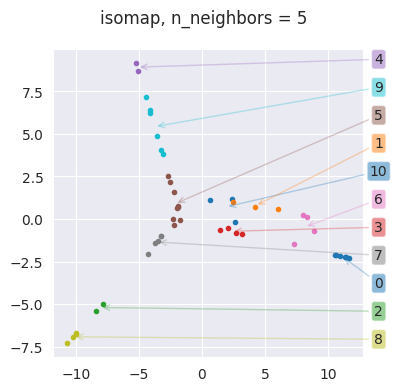

In [207]:
from sklearn.manifold import Isomap

# A sweep over the hyperparameter n_neighbors: [2, 10] found that Isomap
# embedding did not change with hyperparameter. So, we use the default value
# of n_neighbors=5
isou = Isomap(n_neighbors=5).fit_transform(arr)

cluster_means = onp.stack(
    [onp.mean(isou[labels==lbl, :2], axis=0) for lbl in unique_labels]
)

fig, ax_2d = plt.subplots(1,1, figsize=(4,4))
for i, i_lbl in enumerate(onp.argsort(cluster_means[:,1])):
    mask = (labels == unique_labels[i_lbl])
    color = f'C{i_lbl}'
    ax_2d.scatter(isou[mask,0], isou[mask,1], marker='.', color=color)

    # Annotate cluster mean
    y_text = (i+0.5) * 1/n_clusters
    ax_2d.annotate(f"{i_lbl}", cluster_means[i_lbl, :2], xytext=(1.05,y_text), textcoords='axes fraction', ha='center',
                   bbox = dict(boxstyle = 'round,pad=0.2', fc=color, alpha = 0.5),
                   arrowprops = dict(arrowstyle='->', connectionstyle = 'arc3,rad=0', color=color, alpha=0.3))

fig.suptitle(f'isomap, n_neighbors = 5')
plt.show()